# 从零手搓GPT2

In [69]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, #词汇表大小
    "context_length": 1024, #上下文长度
    "emb_dim": 768, #词嵌入维度
    "n_layers": 12, #层数
    "n_heads": 12, #注意力头数
    "drop_rate": 0.1, #dropout率
    "qkv_bias": False #是否使用偏置
}

In [70]:
import torch
import torch.nn as nn

In [71]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"],bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
    
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self,normalized_shape, eps=1e-5):
        super().__init__()
    
    def forward(self, x):
        return x
        

In [72]:
import tiktoken

batch = torch.tensor([[6109,3626,6100,345],
                [6109,1110,6622,257]])

In [73]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [74]:
import torch
import torch.nn as nn

torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(
    nn.Linear(5,6),
    nn.ReLU()
)
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [75]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print(mean,var)



tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>) tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [76]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print(out_norm)
print(mean,var)





tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [77]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # 防止方差为0
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift



In [78]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,keepdim=True,unbiased=False)
print(mean,var)



tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [79]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))))

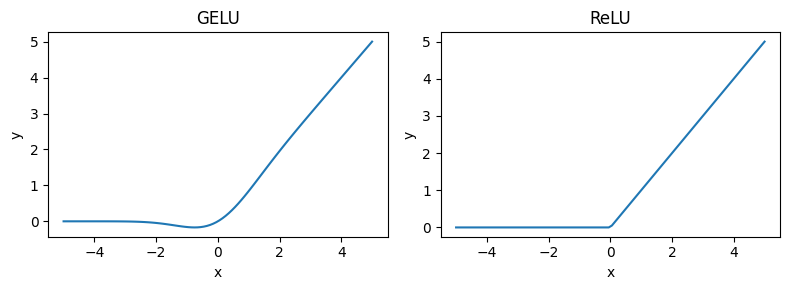

In [80]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-5,5,100)
y_gelu = gelu(x)
y_relu = relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate([(y_gelu, "GELU"), (y_relu, "ReLU")]):
    plt.subplot(1,2,i+1)
    plt.plot(x,y)
    plt.title(label)
    plt.xlabel("x")
    plt.ylabel("y")
plt.tight_layout()
plt.show()


In [81]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [82]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [83]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
                                    nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
                                    nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
                                    nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
                                    nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
                                    ])
    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        
        return x
                




In [84]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [85]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")






In [86]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [87]:
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846951924264431
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976


In [88]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) #构造一个线性层，将多头注意力的输出投影到与输入相同的维度
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape #批次，token数量，输入向量维度
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        context_vec = self.out_proj(context_vec)

        return context_vec

        

In [89]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x



In [90]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)

block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)






Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [91]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"],bias=False)

    def forward(self, in_idx):
        device = in_idx.device
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

        

In [92]:
torch.manual_seed(123)
gpt_model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input:", batch)
print("\nOutput shape:", out.shape)
print(out)



Input: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2153, -0.2156, -0.5981,  ..., -1.3757,  0.0148, -0.4112],
         [-0.3205,  0.1482,  0.1342,  ...,  0.0041,  1.5363,  0.6325],
         [ 0.8451,  1.5721, -0.3732,  ...,  1.2597, -0.5085,  0.5366],
         [ 0.1805,  1.7914, -0.7846,  ...,  1.5559,  0.7674, -0.9654]],

        [[-1.1209,  0.1907, -0.4728,  ..., -1.6933,  0.4509, -0.8067],
         [-0.2541,  0.6058, -0.5057,  ..., -0.0369,  0.4535,  1.1430],
         [ 1.1658,  1.5483, -0.3557,  ..., -0.6638, -0.0425,  0.5066],
         [-0.5266, -0.7271, -0.2477,  ...,  1.9617, -0.0376, -0.4280]]],
       grad_fn=<UnsafeViewBackward0>)


In [93]:
total_params = sum(p.numel() for p in gpt_model.parameters())
print(f"Total parameters: {total_params}")






Total parameters: 163009536


In [94]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output head layer shape:", model.out_head.weight.shape)




Token embedding layer shape: torch.Size([50257, 768])
Output head layer shape: torch.Size([50257, 768])


In [95]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Total parameters of GPT-2: {total_params_gpt2}")






Total parameters of GPT-2: 124412160


In [96]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total size: {total_size_mb:.2f} MB")





Total size: 621.83 MB


In [97]:
def generate_text_simple(model, idx, max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim = -1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx





In [98]:
encoded_tensor = torch.tensor([[15496,11,314,716]])

In [99]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))


Output: tensor([[15496,    11,   314,   716, 12170, 44251, 25952, 49216, 30322,  6868]])
Output length: 10


In [100]:
tokenizer = tiktoken.get_encoding("gpt2")
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded text:", decoded_text)






Decoded text: Hello, I am drone Omni SSLmyra muc native


In [101]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, #词汇表大小
    "context_length": 256, #上下文长度
    "emb_dim": 768, #词嵌入维度
    "n_layers": 12, #层数
    "n_heads": 12, #注意力头数
    "drop_rate": 0.1, #dropout率
    "qkv_bias": False #是否使用偏置
}

In [102]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [103]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model=model, idx = text_to_token_ids(start_context, tokenizer),
                                                max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])

print("Output text:", token_ids_to_text(token_ids, tokenizer))














Output text: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [104]:
inputs = torch.tensor([[16833, 3626, 6100],[40, 1107, 588]])

In [105]:
targets = torch.tensor([[3626, 6100, 345],[1107, 588, 11311]])

In [106]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)






torch.Size([2, 3, 50257])


In [107]:
token_ids = torch.argmax(probas, dim = -1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [108]:
print(f"目标批次 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"目标批次 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"输出批次 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
print(f"输出批次 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")











目标批次 1:  effort moves you
目标批次 2:  really like chocolate
输出批次 1:  Armed heNetflix
输出批次 2:  pressuring empoweredfaith


In [109]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2],targets[text_idx]]
print("文本 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2],targets[text_idx]]
print("文本 2:", target_probas_2)










文本 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
文本 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [110]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)






tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [111]:
avg_log_probas = torch.mean(log_probas)
print(f"平均对数概率: {avg_log_probas}")






平均对数概率: -10.793963432312012


In [112]:
neg_avg_log_probas = avg_log_probas * -1
print(f"负平均对数概率: {neg_avg_log_probas}")

负平均对数概率: 10.793963432312012


In [113]:
print("Logits 形状：", logits.shape)
print("目标 形状", targets.shape)

Logits 形状： torch.Size([2, 3, 50257])
目标 形状 torch.Size([2, 3])


In [114]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("logits_flat 形状：", logits_flat.shape)
print("targets_flat 形状：", targets_flat.shape)






logits_flat 形状： torch.Size([6, 50257])
targets_flat 形状： torch.Size([6])


In [115]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"损失：{loss}")






损失：10.793964385986328


In [116]:
perplexity = torch.exp(loss)
print(f"困惑度: {perplexity}")

困惑度: 48725.8203125


In [117]:
file_path = "/Users/tangren/Documents/Build-a-Large-Language-Model-From-Scratch-/the-verdict.txt"
with open(file_path, "r",encoding="utf-8") as file:
    text_data = file.read()


In [118]:
total_charcter = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"字符总数: {total_charcter}")
print(f"token总数: {total_tokens}")






字符总数: 20479
token总数: 5145


In [119]:
import torch 
from torch.utils.data import Dataset, DataLoader
# 滑动窗口数据采样
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    

            
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True,num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return dataloader

In [ ]:
# 读取文本数据
with open("/Users/tangren/Documents/Build-a-Large-Language-Model-From-Scratch-/the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

# 按90%/10%的比例划分训练集和验证集
total_characters = len(text_data)
split_idx = int(0.90 * total_characters)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(f"总字符数: {total_characters}")
print(f"训练集字符数: {len(train_data)}")
print(f"验证集字符数: {len(val_data)}")

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"], 
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"], 
    shuffle=False,
    num_workers=0
)

总字符数: 20479
训练集字符数: 18431
验证集字符数: 2048


In [121]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)



torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])


In [122]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),
        target_batch.flatten()
    )
    
    return loss

In [123]:
def clac_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
    return total_loss / num_batches





In [124]:
device = torch.device("mps")
model.to(device)
with torch.no_grad():
    train_loss = clac_loss_loader(train_loader, model, device)
    val_loss = clac_loss_loader(val_loader, model, device)

print(f"训练损失: {train_loss}")
print(f"验证损失: {val_loss}")




    

训练损失: 10.98758316040039
验证损失: 10.98110580444336


In [125]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = clac_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = clac_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded =  text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(f"生成样本: {decoded_text}")
    model.train()





In [126]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    token_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            token_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(token_seen)

                print(f"Epoch {epoch+1}/{num_epochs}, Step {global_step}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                
        generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen


In [127]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs = num_epochs,
    eval_freq = 5,
    eval_iter = 5,
    start_context = "Every effort moves you",
    tokenizer = tokenizer
)






Epoch 1/10, Step 0, Train Loss: 9.8168, Val Loss: 9.9238
Epoch 1/10, Step 5, Train Loss: 8.0657, Val Loss: 8.3325
生成样本: Every effort moves you,,,,,,,,,,,,.





































Epoch 2/10, Step 10, Train Loss: 6.6193, Val Loss: 7.0424
Epoch 2/10, Step 15, Train Loss: 6.0457, Val Loss: 6.5960
生成样本: Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Epoch 3/10, Step 20, Train Loss: 5.5236, Val Loss: 6.5077
Epoch 3/10, Step 25, Train Loss: 5.3691, Val Loss: 6.3776
生成样本: Every effort moves you, and to the of the of the picture. Gis.





































Epoch 4/10, Step 30, Train Loss: 4.8300, Val Loss: 6.2628
Epoch 4/10, Step 35, Train Loss: 4.5863, Val Loss: 6.2846
生成样本: Every effort moves you of the
"I the picture.



















"I"I the picture"I had the picture"I the picture and I had been the picture of
Epoch 5/10, Step 40, Train Loss: 3.8794, Val Loss: 6.1303
生成样本: Every effort moves you k

In [128]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="train loss")
    ax1.plot(epochs_seen, val_losses, label="val loss")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("loss")
    ax1.legend(loc = "upper left")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0.5)
    ax2.set_xlabel("tokens seen")
    fig.tight_layout()
    plt.show()
    
    
    
    
    

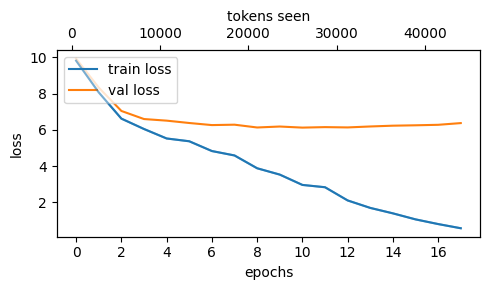

In [130]:
epochs_seen = list(range(len(train_losses)))
plot_losses(epochs_seen, tokens_seen, train_losses, val_losses)

In [131]:
model.to("cpu")
model.eval()







GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [132]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = token_ids_to_text(token_ids, tokenizer)
print(f"生成样本: {decoded_text}")





生成样本: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [133]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [134]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [135]:
probas = torch.softmax(next_token_logits, dim=-1)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [138]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])


forward


In [140]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sample_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)





73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [141]:
def softmax_with_temperature(logits, temperature):
    scaled_logits= logits / temperature
    return torch.softmax(scaled_logits, dim=0)






/var/folders/54/c200w_zx7rgfj5q934zb6vgm0000gn/T/ipykernel_14100/43499487.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vocab.keys(),rotation=90)


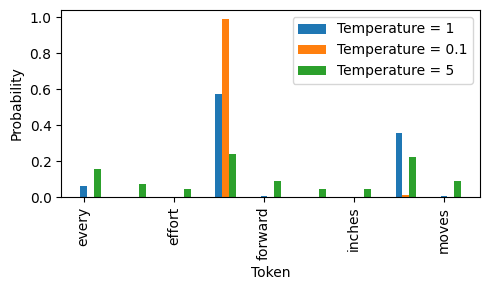

In [144]:
temperature =[1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperature]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperature):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")

ax.set_ylabel('Probability')
ax.set_xlabel('Token')
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [145]:
top_logits = torch.topk(next_token_logits, k=3).values
new_logits = torch.where(next_token_logits <top_logits[-1],torch.tensor(-float("inf")),next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [146]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [160]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits = torch.topk(logits, k=top_k).values
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(-float("inf")).to(logits.device), logits)
        
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [161]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you stand," she down." For Mrs. Gisburn! The women had


In [162]:
torch.save(model.state_dict(), "model.pth")

In [163]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()




GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [164]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),   
},"model_and_optimizer.pth")

In [165]:
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()




GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features